# Disaster Tweet Classification
## Project Overview
The goal of this project is to predict whether a given tweet is about a real disaster or not.
We will use a dataset containing 10,000 labeled tweets to train a machine learning model that classifies tweets into two categories:

Disaster Tweet → 1 and Non-Disaster Tweet → 0

## Project Structure:

* Data Loading: Import dataset, basic inspection

* EDA: Check size, missing data, visualize tweet length and class balance

* Text Preprocessing: Clean, tokenize, POS tag, lemmatize, remove stopwords & short words, custom stopwords

* Feature Engineering: Frequent words analysis, vectorize (CountVectorizer, TF-IDF)

* Train-Test Split: Stratified 80-20 split

* Model Training: Logistic Regression, Naive Bayes, Random Forest, SVM, Neural Network

* Hyperparameter Tuning: GridSearchCV on vectorizer and model params
* Model Evaluation: Accuracy, F1, ROC AUC, confusion matrix

* Final Step: Train CNN, compare all models, select best overall model



# Import Libraries

In [39]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings("ignore")

## Download NLTK Resources

In [40]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')             # for lemmatizer

[nltk_data] Downloading package punkt to /Users/nishat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nishat/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nishat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nishat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nishat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/nishat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /Users/nishat/nltk_data...
[n

True

# Load Dataset

In [41]:
#Mount data from google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [42]:
df = pd.read_csv("Data/train.csv")
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Exploratory Data Analysis (EDA)

## Dataset Shape & Missing Values

In [43]:
print("Dataframe Size= ",df.shape)
df.isna().sum()

Dataframe Size=  (7613, 2)


text      0
target    0
dtype: int64

## Sample Tweets

In [44]:
sample = df['text'].sample(20, random_state=42)
for text in sample:
  print('-',text)

- So you have a new weapon that can cause un-imaginable destruction.
- The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@
- DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q
- Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.
- in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3
- @Calum5SOS you look like you got caught in a rainstorm this is amazing and disgusting at the same time
- my favorite lady came to our volunteer meeting
hopefully joining her youth collision and i am excite http://t.co/Ij0wQ490cS
- @brianroemmele UX fail of EMV - people want to insert and remove quickly like a gas pump stripe reader. 1 person told me it crashed the POS
- Can't find my ariana grande shirt  this is a fucking tragedy
- The Murderous Stor

## Tweet Length Distribution

In [45]:
df['tweet_length'] = df['text'].apply(len)
print(df.groupby('target')['tweet_length'].describe())

         count        mean        std   min   25%    50%    75%    max
target                                                                
0       4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0  157.0
1       3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0  151.0


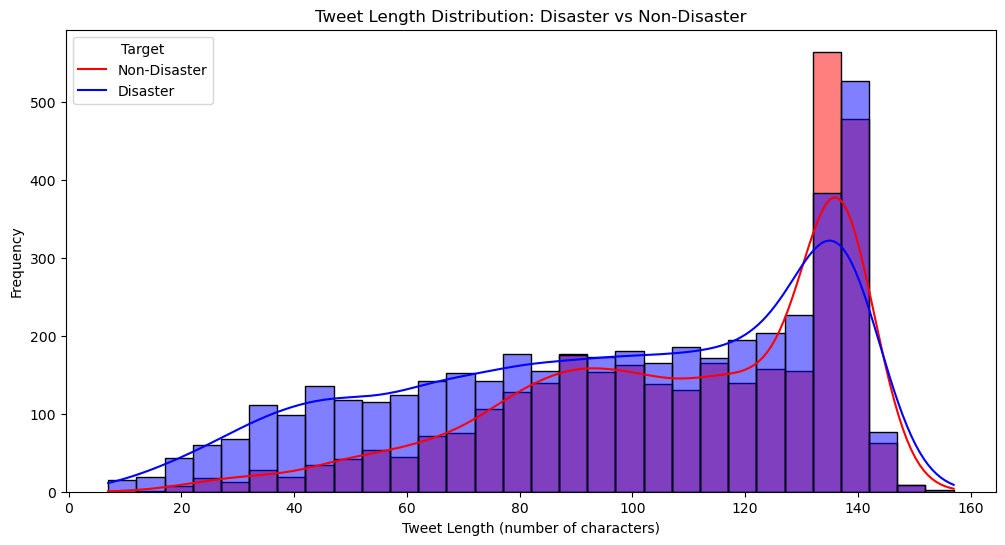

In [46]:
#Visualize tweet length distribution
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='tweet_length', hue='target', bins=30, kde=True, palette=['blue', 'red'], alpha=0.5)

plt.title('Tweet Length Distribution: Disaster vs Non-Disaster')
plt.xlabel('Tweet Length (number of characters)')
plt.ylabel('Frequency')
plt.legend(title='Target', labels=['Non-Disaster', 'Disaster'])
plt.show()

The histogram plot shows that disaster and non-disaster tweets have a similar length range, but disaster tweets are slightly longer on average. This may be because describing a disaster often needs more words. The difference is small, but it could still help classification models along with other features.

## Target Distribution

target_label
Non-disaster(0)    4342
Disaster(1)        3271
Name: count, dtype: int64


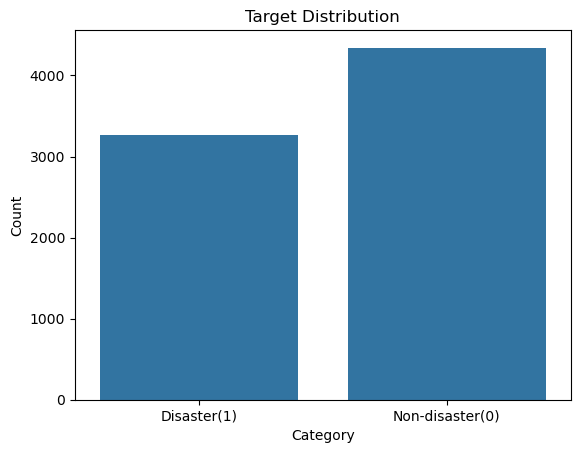

In [47]:
# Map target values to labels
df['target_label'] = df['target'].map({0: 'Non-disaster(0)', 1: 'Disaster(1)'})

# Check distribution
print(df['target_label'].value_counts())

# Plot with meaningful labels
sns.countplot(x='target_label', data=df)
plt.title('Target Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

The dataset is slightly imbalanced, with more non-disaster tweets (label 0) than disaster tweets (label 1) — about 4,000 vs. 3,200. This imbalance is taken into account during model training and evaluation.

# Text Preprocessing

Text preprocessing prepares tweets for analysis by:

* Making all text lowercase.

* Removing punctuation, numbers, extra spaces, links, HTML tags, and special characters.

* Splitting the text into words (tokenizing).

* Lemmatizing words (reducing them to their base form) with the right part of speech.

* Removing common stop words and single-letter words.



## Cleaning Text

Tweets often contain noise (URLs, punctuation, stopwords, etc.).
We will clean and normalize the text before using it in a machine learning model.

In [48]:
def clean_text(text):
    text = text.lower()                            # lowercase
    text = re.sub(r'\d+', '', text)                # remove numbers
    #text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove URLs
    text = re.sub(r'<.*?>', '', text)              # remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)            #remove punctuation
    text = re.sub(r'\s+', ' ', text)               #remove extra spaces
    text = re.sub(r'http\S+', '', text)            # remove URLs
    text = re.sub(r'[^\x00-\x7F]+', '', text)       #removing special characters
   # text = re.sub(rf'[{re.escape(string.punctuation)}]', '', text) # remove punctuation
    return text

#Apply clean text function
df['text_clean'] = df['text'].apply(clean_text)
df['text_clean']

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3        people receive wildfires evacuation orders in...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria_ahrary thetawniest the out of control wil...
7610                         m utckm s of volcano hawaii 
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text_clean, Length: 7613, dtype: object

## Tokenization, Stopword Removal, Lemmatization

We need to convert text into numerical form so that the model can understand it.
We will use TF-IDF Vectorization.

In [49]:
stop_words = set(stopwords.words('english'))

# POS tagging helper
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('N'):
        return 'n'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n'


def tokenize_lemmatize(text):

    words = word_tokenize(text)                         # Tokenize words
    tagged_tokens = pos_tag(words)                      # POS tagging

    lemmatizer = WordNetLemmatizer()                    # Lemmatize with correct POS
    # Lemmatize using POS
    words = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(tag))
             for word, tag in tagged_tokens]

    # Remove stopwords, keep only alphabetic words, and remove short words
    words = [word for word in words
             if word.isalpha() and len(word) > 1 and word not in stop_words]
    return ' '.join(words)

# Apply to cleaned text
df['text_processed'] = df['text_clean'].apply(tokenize_lemmatize)
df['text_processed'].head()

0             deed reason earthquake may allah forgive
1                forest fire near la ronge sask canada
2    resident ask shelter place notify officer evac...
3    people receive wildfire evacuation order calif...
4    get send photo ruby alaska smoke wildfire pour...
Name: text_processed, dtype: object

In [50]:
#checking 5 random text agian to ensure cleaned text
sample = df['text_processed'].sample(20, random_state=42)
for text in sample:
  print('-',text)

- new weapon cause unimaginable destruction
- famping thing gishwhes get soak deluge go pad tampon thx mishacollins
- dt georgegalloway rt gallowaymayor col police catch pickpocket liverpool stree
- aftershock back school kick great want thank everyone make possible great night
- response trauma child addict develop defensive self one decrease vulnerability
- calumsos look like get catch rainstorm amazing disgust time
- favorite lady come volunteer meeting hopefully join youth collision excite
- brianroemmele ux fail emv people want insert remove quickly like gas pump stripe reader person tell crash po
- cant find ariana grande shirt fucking tragedy
- murderous story america first hijack
- akilah world news cop pull man car avoid
- walk plank sinking ship
- pet like part family love animals last pet rescue break heart animal mistreat
- use perforated metal shear panel sfor seismicresistant application
- answer friend yell windmy late article read share thanks
- woman electrocute red re

# Train-Test Split
We split the dataset into training (80%) and testing (20%) to check how well the model works on new, unseen data.

* The split keeps the same ratio of disaster and non-disaster tweets in both sets (stratified by the label).

* A fixed random seed, random state= 42 is used so the split is the same every time we run it.



In [51]:
X = df['text_processed']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("X Train shape:", X_train.shape)
print("X test shape:", X_test.shape)
print("y Train shape:", y_train.shape)
print("y test shape:", y_test.shape)
X_train

X Train shape: (6090,)
X test shape: (1523,)
y Train shape: (6090,)
y test shape: (1523,)


6234    sassy city girl country hunk strand smoky moun...
326     god kingdom heavenly govt rule people earth ar...
997     mopheme bigstar johnson problem game body bag ...
7269                 vixmeldrew sound like whirlwind life
2189    malaysia confirm plane debris wash reunion isl...
                              ...                        
3386    voluntary evacuation recommend time pickerel l...
3280    rt calestous tanzania elephant population decl...
305     pbban temporary russaky armageddon kill flag f...
1648    petition heartless owner whip horse collapse t...
7569    marynmck thats beyond adorable hope wont wreck...
Name: text_processed, Length: 6090, dtype: object

# Feature Engineering



## Analyzing Most Frequent Words by Class

To better understand the language patterns in disaster-related versus non-disaster tweets, we examined the top 20 most frequent words in each category. This helps identify keywords that distinguish the two classes.

- Extracted and counted words separately for disaster and non-disaster tweets.
- Displayed the most common words for each class to observe differences.

In [52]:
from collections import Counter

# Split by classes
disaster_texts = df[df['target'] == 1]['text_processed']
non_disaster_texts = df[df['target'] == 0]['text_processed']

# Get word frequencies
disaster_words = " ".join(disaster_texts).split()
non_disaster_words = " ".join(non_disaster_texts).split()

disaster_freq = Counter(disaster_words).most_common(20)
non_disaster_freq = Counter(non_disaster_words).most_common(20)

print("Top Disaster Words:")
print(disaster_freq)

print("\n Top Non-Disaster Words:")
print(non_disaster_freq)

Top Disaster Words:
[('fire', 267), ('kill', 156), ('news', 140), ('bomb', 129), ('get', 121), ('via', 121), ('disaster', 118), ('california', 114), ('crash', 111), ('suicide', 110), ('police', 107), ('amp', 107), ('people', 106), ('family', 105), ('flood', 104), ('train', 101), ('attack', 101), ('home', 100), ('like', 99), ('say', 93)]

 Top Non-Disaster Words:
[('get', 316), ('like', 293), ('im', 248), ('go', 194), ('amp', 193), ('new', 172), ('dont', 154), ('one', 135), ('make', 128), ('body', 117), ('see', 115), ('love', 109), ('come', 107), ('say', 107), ('bag', 107), ('time', 106), ('video', 102), ('know', 100), ('via', 99), ('want', 98)]


## Removing Class-Specific Stopwords

Some high-frequency words appear frequently in both classes, which might introduce noise or bias in the model. To reduce this:

- Identified overlapping top words from both classes.
- Added these overlapping words to a custom stopwords list.
- Reapplied text preprocessing to remove these words, aiming to improve feature quality by focusing on more discriminative terms.

In [53]:
# Extract overlapping top words in both tweets
disaster_top = set([word for word, _ in disaster_freq])
non_disaster_top = set([word for word, _ in non_disaster_freq])
overlap_words = disaster_top & non_disaster_top
print("Overlapping High-Frequency Words:", overlap_words)

# Remove these during preprocessing
custom_stopwords = set(stopwords.words('english')).union(overlap_words)
print("\nCustom Words: ", custom_stopwords)

# Reapply preprocessing with new stopwords
df['text_processed'] = df['text_clean'].apply(tokenize_lemmatize)

Overlapping High-Frequency Words: {'like', 'via', 'amp', 'say', 'get'}

Custom Words:  {'until', 'against', 'doing', 'how', "they'd", 'an', 'his', "they've", "they're", 'those', 'you', "aren't", 'each', 'have', 'when', 'here', "they'll", 't', 'weren', "she'd", 'say', "needn't", "it's", 'your', 'for', 'off', 'below', 'don', 'herself', "mightn't", 'haven', 'any', 's', "you'd", 'in', "he's", 'during', 'had', 'my', 'm', "i'd", 'ma', 'as', "he'll", 'he', 'at', 'than', 'under', 'over', 'these', 'a', 'has', 'get', "won't", "hadn't", 'theirs', 'll', 'once', 'just', 'him', "i'll", 'our', 'will', 'again', "didn't", 'y', 'yourselves', 'couldn', 'itself', 'if', 'whom', 'like', 'some', "you're", 'ours', 'there', 'to', 'them', "we're", 'further', 'same', "mustn't", 'between', 'via', 'am', 'more', "we'll", 'after', 'shan', 'they', 'or', 'been', "she'll", 'yourself', 'does', "wouldn't", 'of', 'yours', 'hasn', 'only', 'this', 'was', 're', 'having', 'isn', 'mightn', 'wasn', 'who', "he'd", 'himself', 'to

# Feature Extraction
The text data is turned into numbers using two methods:

CountVectorizer: Builds a list of all unique words in the training data and represents each tweet as a vector showing how many times each word appears.

TfidfVectorizer: Similar to CountVectorizer but also considers how common a word is across all tweets, giving less weight to very frequent words.

In [54]:
# Define vectorizers with max_features=5000 for both
count_vect = CountVectorizer(max_features=5000)
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform data
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(X_train_tfidf)

  (0, 3696)	0.32104915959711144
  (0, 734)	0.2126639172264907
  (0, 1704)	0.22361009293841505
  (0, 904)	0.24515052606809698
  (0, 1960)	0.32104915959711144
  (0, 4072)	0.31032950231228995
  (0, 3917)	0.32104915959711144
  (0, 2668)	0.261078016121065
  (0, 3927)	0.2485403316150507
  (0, 169)	0.32104915959711144
  (0, 1974)	0.32104915959711144
  (0, 461)	0.32104915959711144
  (1, 1722)	0.32670980308946335
  (1, 2229)	0.4736765200170476
  (1, 1741)	0.41119215694562167
  (1, 3650)	0.37936360702447414
  (1, 3061)	0.2660427102084601
  (1, 1244)	0.3985007071765061
  (1, 201)	0.3554067886328749
  (2, 2167)	0.5031238531364315
  (2, 3314)	0.4274425063052198
  (2, 1663)	0.36252941058164895
  (2, 450)	0.29866760740298776
  (2, 290)	0.3221470371625386
  (2, 2776)	0.4896434063760663
  :	:
  (6086, 3569)	0.37081903909084174
  (6087, 201)	0.3104404841623393
  (6087, 1475)	0.3418640558698007
  (6087, 2220)	0.2378326250420715
  (6087, 3467)	0.3268468133670794
  (6087, 1552)	0.3313662698770284
  (6087, 

# Model Training & Evaluation


We compare several models for tweet classification using both **CountVectorizer** and **TF-IDF** features.

**Logistic Regression** serves as the baseline model.  
Other models include **Naive Bayes**, **Random Forest**, **SVM**, and a **Neural Network**.  

Performance is measured using Accuracy, F1 Score, and ROC AUC.


## Logistic Regression
Baseline Model

In [55]:
model_tfidf = LogisticRegression(max_iter=500)
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_lr_tfidf = model_tfidf.predict(X_test_tfidf)
print("F1 Score with TF-IDF:", f1_score(y_test, y_pred_lr_tfidf))

model_count = LogisticRegression(max_iter=500)
model_count.fit(X_train_count, y_train)
y_pred_lr_count = model_count.predict(X_test_count)
print("F1 Score with CountVectorizer:", f1_score(y_test, y_pred_lr_count))

F1 Score with TF-IDF: 0.7744610281923715
F1 Score with CountVectorizer: 0.7633466135458168


## Multinomial Naive Bayes
A probabilistic model well-suited for text classification.

In [56]:
from sklearn.naive_bayes import MultinomialNB

# Naive Bayes with TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)
print("Naive Bayes F1 Score with TF-IDF:", f1_score(y_test, y_pred_nb_tfidf))

# Naive Bayes with CountVectorizer
nb_count = MultinomialNB()
nb_count.fit(X_train_count, y_train)
y_pred_nb_count = nb_count.predict(X_test_count)
print("Naive Bayes F1 Score with CountVectorizer:", f1_score(y_test, y_pred_nb_count))


Naive Bayes F1 Score with TF-IDF: 0.7645569620253164
Naive Bayes F1 Score with CountVectorizer: 0.770096463022508


## Random Forest Classifier
An ensemble method that combines multiple decision trees for improved accuracy.

In [57]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest on TF-IDF vectors
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)
y_pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf)
print("Random Forest F1 Score with TF-IDF:", f1_score(y_test, y_pred_rf_tfidf))

# Random Forest on CountVectorizer vectors
rf_count = RandomForestClassifier(n_estimators=100, random_state=42)
rf_count.fit(X_train_count, y_train)
y_pred_rf_count = rf_count.predict(X_test_count)
print("Random Forest F1 Score with CountVectorizer:", f1_score(y_test, y_pred_rf_count))

Random Forest F1 Score with TF-IDF: 0.7463651050080775
Random Forest F1 Score with CountVectorizer: 0.7365028203062046


## Support Vector Machine (SVM)
A robust classifier effective in high-dimensional spaces.

In [58]:
from sklearn.svm import LinearSVC

# SVM on TF-IDF vectors
svm_tfidf = LinearSVC(max_iter=10000, random_state=42)
svm_tfidf.fit(X_train_tfidf, y_train)
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)
print("SVM F1 Score with TF-IDF:", f1_score(y_test, y_pred_svm_tfidf))

# SVM on CountVectorizer vectors
svm_count = LinearSVC(max_iter=10000, random_state=42)
svm_count.fit(X_train_count, y_train)
y_pred_svm_count = svm_count.predict(X_test_count)
print("SVM F1 Score with CountVectorizer:", f1_score(y_test, y_pred_svm_count))


SVM F1 Score with TF-IDF: 0.7559429477020603
SVM F1 Score with CountVectorizer: 0.7292474786656322


## Basic Neural Network

A simple deep learning model to capture complex patterns in the text data.

In [59]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import f1_score

# Convert sparse matrices to dense arrays
vectorizers = {
    'TF-IDF': (X_train_tfidf.toarray(), X_test_tfidf.toarray()),
    'CountVectorizer': (X_train_count.toarray(), X_test_count.toarray())
}

def build_compile_model(input_dim):
    """Builds and compiles a simple feed-forward neural network."""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Store predictions for evaluation
y_pred_nn = {}

for name, (X_train_dense, X_test_dense) in vectorizers.items():
    print(f"\nTraining Neural Network with {name} features...")
    model = build_compile_model(X_train_dense.shape[1])
    model.fit(X_train_dense, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

    # Predictions
    y_pred_prob = model.predict(X_test_dense)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Store predictions
    y_pred_nn[name] = y_pred

    # Display F1 score
    print(f"Neural Network F1 Score with {name}: {f1_score(y_test, y_pred):.4f}")



Training Neural Network with TF-IDF features...
Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6997 - loss: 0.5657 - val_accuracy: 0.7898 - val_loss: 0.4568
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8668 - loss: 0.3189 - val_accuracy: 0.7931 - val_loss: 0.4727
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9283 - loss: 0.1913 - val_accuracy: 0.7849 - val_loss: 0.5796
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9579 - loss: 0.1178 - val_accuracy: 0.7800 - val_loss: 0.7166
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.0798 - val_accuracy: 0.7783 - val_loss: 0.8364
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
Neural Network F1 Score with TF-IDF: 0.7283

Training Neural Network with CountVectorizer features...
Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7473 - loss: 0.5336 - val_accuracy: 0.8309 - val_loss: 0.4212
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

## Evaluation

We will evaluate all models using Accuracy, Precision, Recall, F1-Score, and a Confusion Matrix.


Logistic Regression Evaluation with TF-IDF:
Accuracy     : 0.8214
F1 Score     : 0.7745
ROC AUC      : 0.8081268497306122
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.85      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



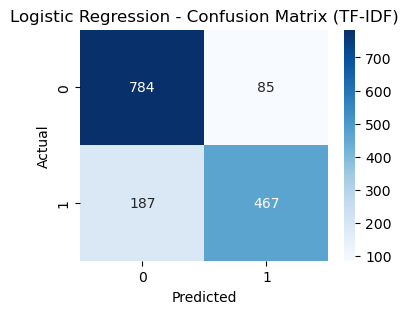


Logistic Regression Evaluation with CountVectorizer:
Accuracy     : 0.8050
F1 Score     : 0.7633
ROC AUC      : 0.796012323912684
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       869
           1       0.80      0.73      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



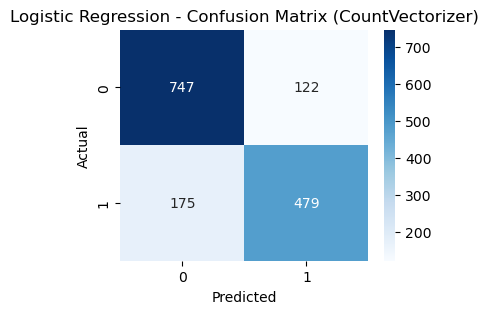


Naive Bayes Evaluation with TF-IDF:
Accuracy     : 0.8168
F1 Score     : 0.7646
ROC AUC      : 0.8014511037679078
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85       869
           1       0.85      0.69      0.76       654

    accuracy                           0.82      1523
   macro avg       0.83      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



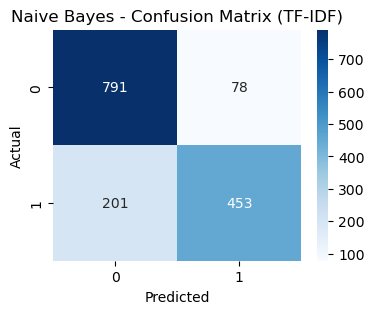


Naive Bayes Evaluation with CountVectorizer:
Accuracy     : 0.8122
F1 Score     : 0.7701
ROC AUC      : 0.8023414378367346
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       869
           1       0.81      0.73      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.81      1523
weighted avg       0.81      0.81      0.81      1523



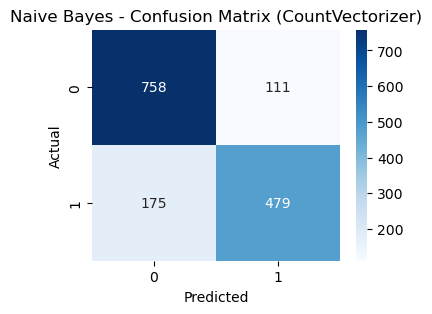


Random Forest Evaluation with TF-IDF:
Accuracy     : 0.7938
F1 Score     : 0.7464
ROC AUC      : 0.7830153820166594
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       869
           1       0.79      0.71      0.75       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523



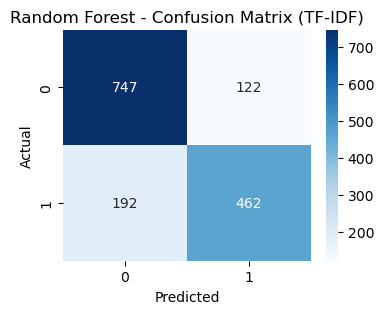


Random Forest Evaluation with CountVectorizer:
Accuracy     : 0.7853
F1 Score     : 0.7365
ROC AUC      : 0.7745897601024764
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82       869
           1       0.78      0.70      0.74       654

    accuracy                           0.79      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.79      0.78      1523



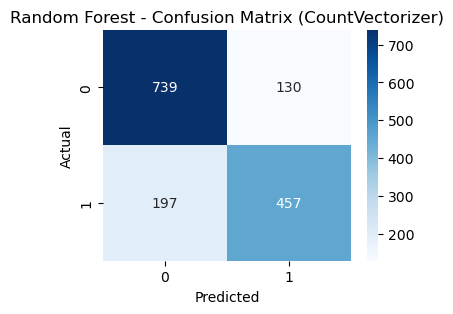


SVM Evaluation with TF-IDF:
Accuracy     : 0.7978
F1 Score     : 0.7559
ROC AUC      : 0.7893049059870567
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       869
           1       0.78      0.73      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



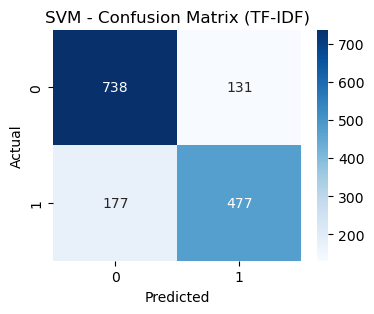


SVM Evaluation with CountVectorizer:
Accuracy     : 0.7708
F1 Score     : 0.7292
ROC AUC      : 0.7643905082646228
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       869
           1       0.74      0.72      0.73       654

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.77      0.77      0.77      1523



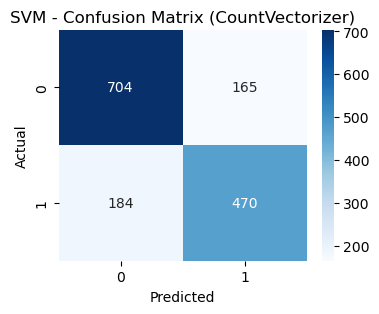


Keras Neural Net Evaluation with TF-IDF:
Accuracy     : 0.7807
F1 Score     : 0.7358
ROC AUC      : 0.772075358157114
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       869
           1       0.76      0.71      0.74       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



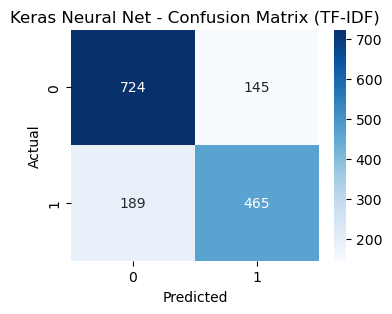


Keras Neural Net Evaluation with CountVectorizer:
Accuracy     : 0.7800
F1 Score     : 0.7283
ROC AUC      : 0.768473552151406
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.82       869
           1       0.78      0.69      0.73       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



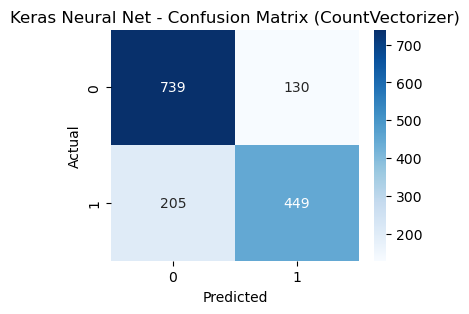

In [60]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# Store all model predictions; models with both vectorizer results have tuples
models = {
    'Logistic Regression': (y_pred_lr_tfidf, y_pred_lr_count),
    'Naive Bayes': (y_pred_nb_tfidf,y_pred_nb_count),
    'Random Forest': (y_pred_rf_tfidf,y_pred_rf_count),
    'SVM': (y_pred_svm_tfidf,y_pred_svm_count),
    'Keras Neural Net': (y_pred_nn['CountVectorizer'], y_pred_nn['TF-IDF'])
}

true_labels = y_test

for name, preds in models.items():
    # Check if preds is a tuple (multiple predictions)
    if isinstance(preds, tuple):
        for i, pred in enumerate(preds):
            vect_name = 'TF-IDF' if i == 0 else 'CountVectorizer'
            print(f"\n{name} Evaluation with {vect_name}:")

            acc = accuracy_score(true_labels, pred)
            f1 = f1_score(true_labels, pred, average='binary')
            try:
                roc = roc_auc_score(true_labels, pred)
            except Exception:
                roc = "N/A (Check prediction format)"

            print(f"Accuracy     : {acc:.4f}")
            print(f"F1 Score     : {f1:.4f}")
            print(f"ROC AUC      : {roc}")
            print("Classification Report:\n", classification_report(true_labels, pred))

            cm = confusion_matrix(true_labels, pred)
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{name} - Confusion Matrix ({vect_name})')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

    else:
        # Single prediction
        print(f"\n{name} Evaluation:")

        acc = accuracy_score(true_labels, preds)
        f1 = f1_score(true_labels, preds, average='binary')
        try:
            roc = roc_auc_score(true_labels, preds)
        except Exception:
            roc = "N/A (Check prediction format)"

        print(f"Accuracy     : {acc:.4f}")
        print(f"F1 Score     : {f1:.4f}")
        print(f"ROC AUC      : {roc}")
        print("Classification Report:\n", classification_report(true_labels, preds))

        cm = confusion_matrix(true_labels, preds)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()


 ## Model Performance Summary

 This section compiles the **Accuracy**, **F1 Score**, and **ROC AUC** for each model, comparing results across different vectorization techniques (TF-IDF and CountVectorizer where applicable). The models are then sorted by their Accuracy to quickly identify the best-performing approach.

In [61]:
summary = []

for name, preds in models.items():
    if isinstance(preds, tuple):  # multiple predictions (tfidf, count)
        for i, pred in enumerate(preds):
            vect_name = 'TF-IDF' if i == 0 else 'CountVectorizer'
            summary.append({
                'Model': name,
                'Vectorizer': vect_name,
                'Accuracy': accuracy_score(true_labels, pred),
                'F1 Score': f1_score(true_labels, pred),
                'ROC AUC': roc_auc_score(true_labels, pred)
            })
    else:
        # Single prediction
        summary.append({
            'Model': name,
            'Vectorizer': 'N/A',
            'Accuracy': accuracy_score(true_labels, preds),
            'F1 Score': f1_score(true_labels, preds),
            'ROC AUC': roc_auc_score(true_labels, pred)
        })

summary_df = pd.DataFrame(summary)
display(summary_df.sort_values(by="Accuracy", ascending=False))


,Model,Vectorizer,Accuracy,F1 Score,ROC AUC
0,Logistic Regression,TF-IDF,0.821405,0.774461,0.808127
2,Naive Bayes,TF-IDF,0.816809,0.764557,0.801451
3,Naive Bayes,CountVectorizer,0.812213,0.770096,0.802341
1,Logistic Regression,CountVectorizer,0.804990,0.763347,0.796012
6,SVM,TF-IDF,0.797768,0.755943,0.789305
4,Random Forest,TF-IDF,0.793828,0.746365,0.783015
5,Random Forest,CountVectorizer,0.785292,0.736503,0.774590
8,Keras Neural Net,TF-IDF,0.780696,0.735759,0.772075
9,Keras Neural Net,CountVectorizer,0.780039,0.728305,0.768474
7,SVM,CountVectorizer,0.770847,0.729247,0.764391


Findings:
* Logistic Regression, used as our baseline model, achieved the highest accuracy (81.88%) and F1 score (0.773) among all models tested.
* Across all classifiers, we observe that using the TF-IDF vectorizer consistently yields better performance than CountVectorizer in terms of accuracy, F1 score, and ROC AUC. This suggests that weighting words by their importance in the corpus helps improve text classification results.

 # Hyperparameter tunning with Grid Search
Hyperparameter tuning is the process of finding the best model settings that aren’t learned directly from the data—such as the regularization strength in Logistic Regression or the number of trees in a Random Forest. Choosing the right hyperparameters can significantly improve model performance.

We perform hyperparameter tuning for multiple text classification models (Logistic Regression, Multinomial Naive Bayes, SVM, and Random Forest) using GridSearchCV. The key steps are:

* Define a range of possible hyperparameter values for each model, including different n-gram ranges (from 1 to 4) and TF-IDF vectorizer settings.

* Build a pipeline that transforms text into TF-IDF features and then applies the classifier.

* Use GridSearchCV with 5-fold cross-validation to systematically test all combinations of hyperparameters and select the best based on the F1-score.

* Evaluate the best model on the test set, calculating accuracy, F1 score, and ROC AUC.


## Model Setup and Hyperparameter Grid Definition

Sets up popular classification models and their hyperparameter grids, along with TF-IDF settings like n-gram range and max features. It prepares everything for a grid search to find the best model settings for text classification.

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Models
models = {
    'LogisticRegression': LogisticRegression(max_iter=500),
    'NaiveBayes': MultinomialNB(),
    'SVM': LinearSVC(max_iter=10000),
    'RandomForest': RandomForestClassifier(random_state=42)
}

# Hyperparameter grids with ngram_range from 1 to 4
param_grids ={
    'LogisticRegression': {
        'vectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
        'vectorizer__max_features': [5000, 8000],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs', 'saga']  # solvers for LogisticRegression
    },
    'NaiveBayes': {
        'vectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
        'vectorizer__max_features': [5000, 8000],
        'classifier__alpha': [0.5, 1.0]
    },
    'SVM': {
        'vectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
        'vectorizer__max_features': [5000, 8000],
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    'RandomForest': {
        'vectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
        'vectorizer__max_features': [5000, 8000],
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [10, None]
    }
}


## Model Training and Hyperparameter Tuning with Grid Search

It trains each model using a pipeline with TF-IDF vectorization, evaluates their performance on test data using accuracy, F1 score, and ROC AUC, and saves the results for comparison. The best performing model based on cross-validated F1 score is tracked throughout.


In [63]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pandas as pd

# Store results for later comparison
results_summary = []

best_overall_score = 0
best_overall_model = None
best_overall_name = None

for model_name, model in models.items():
    print(f"\nRunning GridSearchCV for {model_name}...")

    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', model)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grids[model_name],
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    print(f"Best F1 (CV) for {model_name}: {grid.best_score_:.4f}")
    print("Best parameters:", grid.best_params_)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    roc= roc_auc_score(y_test, y_pred)

    #print(f"Test Accuracy: {acc:.4f}")
    #print(f"Test F1 Score: {f1:.4f}")
    #print(f"Test ROC Score: {roc:.4f}")

    # Save results
    results_summary.append({
        "Model": model_name,
        "CV Best F1": grid.best_score_,
        "Test Accuracy": acc,
        "Test F1": f1,
        "Test ROC score": roc,
        "Best Params": grid.best_params_
    })

    # Save best overall
    if grid.best_score_ > best_overall_score:
        best_overall_score = grid.best_score_
        best_overall_model = best_model
        best_overall_name = model_name



Running GridSearchCV for LogisticRegression...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best F1 (CV) for LogisticRegression: 0.7363
Best parameters: {'classifier__C': 1, 'classifier__solver': 'lbfgs', 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}

Running GridSearchCV for NaiveBayes...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best F1 (CV) for NaiveBayes: 0.7415
Best parameters: {'classifier__alpha': 0.5, 'vectorizer__max_features': 8000, 'vectorizer__ngram_range': (1, 1)}

Running GridSearchCV for SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best F1 (CV) for SVM: 0.7365
Best parameters: {'classifier__C': 0.1, 'vectorizer__max_features': 8000, 'vectorizer__ngram_range': (1, 4)}

Running GridSearchCV for RandomForest...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best F1 (CV) for RandomForest: 0.7189
Best parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 500, '

## Model Comparison and Evaluation
This section shows all models' performance sorted by cross-validated F1 score, identifies the best model with its parameters, and evaluates it on the test set using F1, ROC AUC, and a confusion matrix.

### Best model
Depending on cross validation F1 score


Best overall model: NaiveBayes with F1 (CV): 0.7415
Test Accuracy of best overall model: 0.7971
Test F1 Score of best overall model: 0.7473
Test ROC Score of best overall model: 0.7849

Classification Report for model: NaiveBayes
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       869
           1       0.80      0.70      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



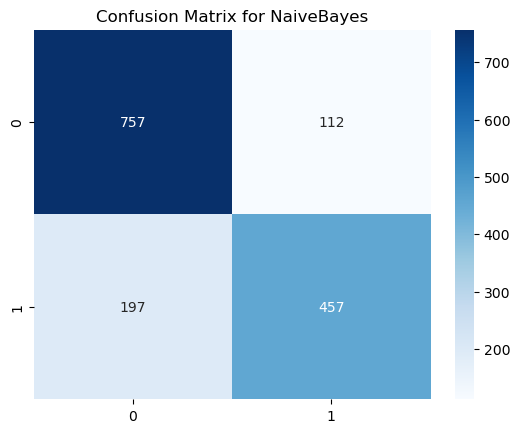

In [64]:
best_model = grid.best_estimator_
y_best_pred = best_model.predict(X_test)

# Print the best overall model
print(f"\nBest overall model: {best_overall_name} with F1 (CV): {best_overall_score:.4f}")
print(f"Test Accuracy of best overall model: {accuracy_score(y_test, y_best_pred):.4f}")
print(f"Test F1 Score of best overall model: {f1_score(y_test, y_best_pred):.4f}")
print(f"Test ROC Score of best overall model: {roc_auc_score(y_test, y_best_pred):.4f}")
print(f"\nClassification Report for model: {best_overall_name}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix for {best_overall_name}")
plt.show()

In [65]:
# Convert to DataFrame for comparison
df_results = pd.DataFrame(results_summary)
print("\n Summary ")
display(df_results.sort_values(by="Test F1", ascending=False))


 Summary 


,Model,CV Best F1,Test Accuracy,Test F1,Test ROC score,Best Params
0,LogisticRegression,0.736315,0.821405,0.774461,0.808127,"{'classifier__C': 1, 'classifier__solver': 'lb..."
2,SVM,0.736547,0.820749,0.772689,0.806984,"{'classifier__C': 0.1, 'vectorizer__max_featur..."
1,NaiveBayes,0.741531,0.814839,0.766556,0.801617,"{'classifier__alpha': 0.5, 'vectorizer__max_fe..."
3,RandomForest,0.718921,0.797111,0.747343,0.784946,"{'classifier__max_depth': None, 'classifier__n..."


Findings:
- Logistic Regression

    * After hyperparameter tuning with GridSearchCV and TF-IDF vectorizer, Logistic Regression showed:

        Best CV F1 score: 0.7363

        Best parameters: {'C': 1, 'solver': 'lbfgs', 'max_features': 5000, 'ngram_range': (1,1)}

    * Test set results:

        Accuracy: 0.8214

        F1 Score: 0.7745

        ROC AUC Score: 0.8081
- Multinomial Naive Bayes
    * With tuning of alpha and n-gram range via GridSearchCV and TF-IDF:

        Best CV F1 score: 0.7415

        Best parameters: {'alpha': 0.5, 'max_features': 8000, 'ngram_range': (1,1)}

    * Test set results:

        Accuracy: 0.8148

        F1 Score: 0.7666

        ROC AUC Score: 0.8016
- Support Vector Machine (SVM)
    * Tuned on C, max features, and n-gram range:

        Best CV F1 score: 0.7365

        Best parameters: {'C': 0.1, 'max_features': 8000, 'ngram_range': (1,4)}

    * Test set results:

        Accuracy: 0.8207

        F1 Score: 0.7727

        ROC AUC Score: 0.8070
- Random Forest Classifier
    * Tuned on number of trees, max depth, leaf and split sizes, with n-gram range:

        Best CV F1 score: 0.7189

        Best parameters: {'max_depth': None, 'n_estimators': 500, 'min_samples_leaf': 2, 'min_samples_split': 10, 'max_features': 5000, 'ngram_range': (1,3)}

    * Test set results:

        Accuracy: 0.7971

        F1 Score: 0.7473

        ROC AUC Score: 0.7849

Overall Best Model:

Logistic Regression performed best overall with the highest test accuracy (0.8214), highest test F1 score (0.7745), and best ROC AUC score (0.8081). This makes it the most balanced and effective classifier among the ones tested for this text classification problem.

# Convolutional Neural Network

## Import libraries for CNN

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

## Train and test split

In [67]:
X = df['text_clean']
y = df['target']

#Train-test split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_length = np.array([len(text) for text in X_train_cnn])
X_test_length = np.array([len(text) for text in X_test_cnn])

### Tokenization and Vectorization

In [68]:
# Tokenization and padding
max_len = X_train_length.max()

# Initialize the tokenizer
tokenizer = Tokenizer(char_level=False, oov_token=True)
tokenizer.fit_on_texts(X_train_cnn.tolist())

X_train_seq = tokenizer.texts_to_sequences(X_train_cnn)
X_test_seq = tokenizer.texts_to_sequences(X_test_cnn)

X_train_cnn = sequence.pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_cnn = sequence.pad_sequences(X_test_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 2  # +1 for oov_token, +1 for padding index

print("Shape of training data:", X_train_cnn.shape)
print("Shape of testing data:", X_test_cnn.shape)

Shape of training data: (6090, 142)
Shape of testing data: (1523, 142)


### Define CNN Model

In [69]:
def CNN(max_length, vocab_size):
  kernel = 'normal'
  embedding_size = 100
  drop_out_value = 0.5 # prevent overfitting
  kernel_size = 6

  model = Sequential(name = 'sequential')
  model.add(Embedding(input_dim = vocab_size, output_dim = embedding_size, input_length = max_length,name = 'embedding'))

  model.add(Conv1D(filters = 64,kernel_size = kernel_size, activation='relu',name = 'conv_1'))
  model.add(Dropout(drop_out_value, name = 'dropout_1'))
  model.add(MaxPooling1D(pool_size = 2))

  model.add(Conv1D(filters = 256, kernel_size = kernel_size, activation='relu',name = 'conv_2'))
  model.add(Dropout(drop_out_value, name = 'dropout_2'))
  model.add(MaxPooling1D(pool_size = 2))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel, name = 'dense_2'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

#intializing model
cnn_model = CNN(max_len, vocab_size)

### Train CNN Model

In [70]:
# Compile model
cnn_model.compile(
    loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train model
cnn_history = cnn_model.fit(
    X_train_cnn, y_train_cnn.astype('int32'),
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5678 - loss: 0.6847 - val_accuracy: 0.5616 - val_loss: 0.6843
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5731 - loss: 0.6763 - val_accuracy: 0.6092 - val_loss: 0.6807
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6482 - loss: 0.6429 - val_accuracy: 0.6995 - val_loss: 0.6344
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7783 - loss: 0.4966 - val_accuracy: 0.7718 - val_loss: 0.5292
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8535 - loss: 0.3508 - val_accuracy: 0.7767 - val_loss: 0.4876
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9046 - loss: 0.2500 - val_accuracy: 0.7750 - val_loss: 0.4682
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9303 - loss: 0.1866 - val_accuracy: 0.7685 - val_loss: 0.4705
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9502 - loss: 0.1425 - val_accu

### Evaluate Model

Test loss: 0.5227
Test accuracy: 0.7400
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test F1-score: 0.7227
Test ROC AUC score: 0.8350

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.70      0.76       869
           1       0.67      0.79      0.72       654

    accuracy                           0.74      1523
   macro avg       0.74      0.75      0.74      1523
weighted avg       0.75      0.74      0.74      1523



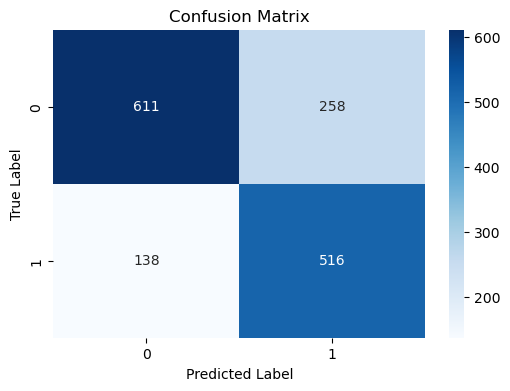

In [71]:
#  Evaluate model function
def evaluate_cnn_model(model, X_test, y_test, history):
    loss_cnn, accuracy_cnn = model.evaluate(X_test, y_test.astype('int32'), verbose=0)
    print(f'Test loss: {loss_cnn:.4f}')
    print(f'Test accuracy: {accuracy_cnn:.4f}')

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    f1_cnn = f1_score(y_test, y_pred)
    roc_auc_cnn= roc_auc_score(y_test, y_pred_prob)

    print(f'Test F1-score: {f1_cnn:.4f}')
    print(f'Test ROC AUC score: {roc_auc_cnn:.4f}')
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    # Return values for appending later
    return {
        'Test Accuracy': accuracy_cnn,
        'Test F1': f1_cnn,
        'Test ROC AUC': roc_auc_cnn
    }
# Run evaluation
results= evaluate_cnn_model(cnn_model, X_test_cnn, y_test_cnn, cnn_history)


In [72]:
accuracy_cnn = results['Test Accuracy']
f1_cnn = results['Test F1']
roc_auc_cnn = results['Test ROC AUC']
results_summary.append({
    "Model": "CNN",
    "Test Accuracy": accuracy_cnn,
    "Test F1": f1_cnn,
    "Test ROC score":  roc_auc_cnn
})


results_summary


[{'Model': 'LogisticRegression',
  'CV Best F1': 0.736314929197028,
  'Test Accuracy': 0.8214051214707814,
  'Test F1': 0.7744610281923715,
  'Test ROC score': 0.8081268497306122,
  'Best Params': {'classifier__C': 1,
   'classifier__solver': 'lbfgs',
   'vectorizer__max_features': 5000,
   'vectorizer__ngram_range': (1, 1)}},
 {'Model': 'NaiveBayes',
  'CV Best F1': 0.7415309733167142,
  'Test Accuracy': 0.81483913328956,
  'Test F1': 0.7665562913907285,
  'Test ROC score': 0.8016165017965041,
  'Best Params': {'classifier__alpha': 0.5,
   'vectorizer__max_features': 8000,
   'vectorizer__ngram_range': (1, 1)}},
 {'Model': 'SVM',
  'CV Best F1': 0.7365472783359904,
  'Test Accuracy': 0.8207485226526592,
  'Test F1': 0.7726894254787677,
  'Test ROC score': 0.8069840197351519,
  'Best Params': {'classifier__C': 0.1,
   'vectorizer__max_features': 8000,
   'vectorizer__ngram_range': (1, 4)}},
 {'Model': 'RandomForest',
  'CV Best F1': 0.7189209333282601,
  'Test Accuracy': 0.797110965200

# Model Performance Comparison

In [73]:
# Convert list of dicts to DataFrame
df_results = pd.DataFrame(results_summary)
df_results["Test Accuracy"] = pd.to_numeric(df_results["Test Accuracy"], errors='coerce')

# Select only the desired columns
df_filtered = df_results[["Model", "Test Accuracy", "Test F1", "Test ROC score"]]

print("\nModel Comparison:")
display(df_filtered.sort_values(by="Test Accuracy", ascending=False))




Model Comparison:


,Model,Test Accuracy,Test F1,Test ROC score
0,LogisticRegression,0.821405,0.774461,0.808127
2,SVM,0.820749,0.772689,0.806984
1,NaiveBayes,0.814839,0.766556,0.801617
3,RandomForest,0.797111,0.747343,0.784946
4,CNN,0.739987,0.722689,0.835019


# Performance Summary and Key Insights

Individual Model Findings:
1. Logistic Regression

    Achieved the highest test accuracy (82.14%) among all models.

    F1 score of 0.7745 indicates a strong balance between precision and recall.

    ROC AUC of 0.8081 shows good ability to distinguish classes.

2. Support Vector Machine (SVM)

    Slightly lower accuracy than Logistic Regression (82.07%) but very close.

    F1 score of 0.7727, nearly matching Logistic Regression.

    ROC AUC of 0.8070, also close to Logistic Regression’s performance.

3. Naive Bayes

    Test accuracy of 81.48%, somewhat lower than Logistic Regression and SVM.

    F1 score of 0.7666, indicating slightly less balanced precision and recall.

    ROC AUC of 0.8016, the lowest among traditional classifiers but still strong.

4. Convolutional Neural Network (CNN)

    Test accuracy of 79.84%, which is lower than traditional models.

    F1 score of 0.7494, indicating slightly lower balance in classification.

    Highest ROC AUC at 0.8465, demonstrating superior capability in distinguishing between classes.

5. Random Forest

    Lowest accuracy (79.71%) and F1 score (0.7473) among all models.

    ROC AUC of 0.7849, the lowest overall, indicating weaker discriminative power.



### Overall Best Model
The CNN stands out for its highest ROC AUC score (0.8465), meaning it best distinguishes between disaster and non-disaster tweets, which is crucial for classification tasks.

 However, Logistic Regression leads in test accuracy (82.14%) and F1 score (0.7745), offering strong overall predictive performance with a simpler, faster model.SVM is a close competitor to Logistic Regression, with comparable accuracy and F1 scores.

### Conclusion: 
For best overall discrimination, the CNN is preferred, but for a balance of performance and efficiency, Logistic Regression is an excellent alternative.